In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
from collections import OrderedDict

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from tqdm import tqdm

from models.t0 import T0RegressionModel
from datahandles import TabLLMDataObject, FewshotTabLLMDataset, CombinedTabLLMTextDataset
from tabllm.dataset_utils import balance_dataset, load_and_preprocess_dataset
from utils import Config, ConfigObject

os.environ["HF_HOME"] = "/export/pasan/.cache/huggingface"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/afs/glue.umd.edu/home/glue/p/a/pasand/home/miniconda3/envs/transhyper2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, cmap='Blues'):
    """
    Displays a confusion matrix.

    Parameters:
    - y_true: list or array of true labels
    - y_pred: list or array of predicted labels
    - class_names: list of class names (optional)
    - normalize: whether to normalize the matrix (default: False)
    - cmap: color map for the heatmap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()

In [4]:
checkpoint_path = f"save/t0pp-twotrain-bank-income/epoch-6.pth"

checkpoint = torch.load(checkpoint_path, weights_only=False)
cfg = Config(cfg_dict=checkpoint["cfg"])
model = T0RegressionModel(cfg=cfg)
model.load_state_dict(checkpoint['model'])
tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer.model())

Hyponet mlp initialized with parameter shapes {'wb0': (104, 10), 'wb1': (11, 10), 'wb2': (11, 10), 'wb3': (11, 2)}
Initializing hypernet t0, name: t0, model: bigscience/T0pp
t0 hypernet hidden size: 4096
total hyponet params: 1282


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [12]:
def load_tabllm_datasets(train_list:list, test_list:list, balanced:dict, test_ratio:float, train_ratio:float):
    cfg_dict = checkpoint["cfg"]
    cfg_dict["datasets"]["list_combine_test"] = test_list
    cfg_dict["datasets"]["list_combine_train"] = train_list
    cfg_dict["datasets"]["balanced"] = balanced
    cfg_dict["datasets"]["tabllm"]["txt_data_path"] = "tabllm/data/datasets_serialized"
    cfg_dict["datasets"]["test_ratio"] = test_ratio
    cfg_dict["datasets"]["train_ratio"] = train_ratio
    cfg_dict["datasets"]["test_size"] = ""
    cfg_dict["datasets"]["train_size"] = ""
    cfg_dict["debug"] = False
    cfg = Config(cfg_dict=cfg_dict)

    tabllm_do = TabLLMDataObject(cfg=cfg, set_hyponet_in_dim=False)
    test_ds = CombinedTabLLMTextDataset(cfg=cfg, 
                                        split="test", 
                                        datapoints=[tabllm_do.split_datapoints[ds_name] for ds_name in test_list],
                                        max_n_features=cfg.hyponet.in_dim())
    train_ds = CombinedTabLLMTextDataset(cfg=cfg, 
                                         split="train", 
                                         datapoints=[tabllm_do.split_datapoints[ds_name] for ds_name in train_list], 
                                         max_n_features=cfg.hyponet.in_dim())

    y_test = np.array([test_ds[i]["y"] for i in range(len(test_ds))])
    X_test = np.array([test_ds[i]["x"] for i in range(len(test_ds))])

    y_train = np.array([train_ds[i]["y"] for i in range(len(train_ds))])
    X_train = np.array([train_ds[i]["x"] for i in range(len(train_ds))])
    print(f"test_list: {test_list}, X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}\ntrain_list: {train_list}, X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
    return X_test, y_test, test_ds, X_train, y_train, train_ds

# Hyponet layer-wise similarity

In [24]:
def dict_to_mlp(weight_dict: dict[str, torch.Tensor], in_dim:int) -> nn.Sequential:
    """
    Convert a dictionary of 'wbX' -> tensor(out_features, in_features+1)
    into a PyTorch MLP with the given weights and biases.
    
    Args:
        weight_dict: dict with keys like 'wb0', 'wb1', ... and tensors 
                     where the last column is the bias.
    
    Returns:
        model: nn.Sequential containing the layers with weights loaded.
    """
    layers = []
    
    # Sort layers by number (wb0, wb1, ...)
    sorted_keys = sorted(weight_dict.keys(), key=lambda k: int(k[2:]))
    
    for i, key in enumerate(sorted_keys):
        in_dim = in_dim + 1 # inputs and bias
        wb = weight_dict[key][0]
        out_dim = len(wb) // in_dim
        wb = torch.reshape(wb, (in_dim, out_dim))

        in_features = in_dim - 1  # last col = bias
        out_features = out_dim
        bias = wb[-1, :]
        weight = wb[:-1, :]
        
        # Create linear layer
        layer = nn.Linear(in_features, out_features)
        
        # Assign weights and bias (ensure no grad issues)
        with torch.no_grad():
            layer.weight.copy_(torch.transpose(weight, 0 ,1))
            layer.bias.copy_(bias)
        
        layers.append(layer)
        
        # Optionally add non-linearity (ReLU here, skip after last)
        if i < len(sorted_keys) - 1:
            layers.append(nn.ReLU())

        in_dim = out_dim
    
    return nn.Sequential(*layers)

def get_layer_outputs(model, layers_to_hook):
    """
    Registers forward hooks on specified layers and returns a function to get their outputs.

    Args:
        model (nn.Module): The model to hook.
        layers_to_hook (list[str]): List of layer names (use model.named_modules()) to hook.

    Returns:
        - hook_handles: list of hook handles (for later removal).
        - get_outputs: function that takes an input and returns activations from hooked layers.
    """
    activations = OrderedDict()

    def hook_fn(name):
        def fn(module, input, output):
            # Flatten output for CKA computation: [batch_size, features]
            activations[name] = output.view(output.size(0), -1).detach()
        return fn

    hook_handles = []
    for name, module in model.named_modules():
        if name in layers_to_hook:
            handle = module.register_forward_hook(hook_fn(name))
            hook_handles.append(handle)

    def get_outputs(x):
        activations.clear()  # Clear before forward pass
        _ = model(x)
        return [activations[name] for name in layers_to_hook]

    return hook_handles, get_outputs

def center_kernel(K: np.ndarray) -> np.ndarray:
    """
    Center a kernel matrix using the double centering formula:
    K_c = K - 1K - K1 + 1K1
    """
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    return K_centered

def cka_matrix(X: np.ndarray, Y: np.ndarray) -> float:
    """
    Compute the Centered Kernel Alignment (CKA) between two sets of representations.
    
    Args:
        X: (n_samples, d1) activations/logits from model 1
        Y: (n_samples, d2) activations/logits from model 2
    
    Returns:
        Scalar CKA similarity between X and Y
    """
    Kx = X @ X.T
    Ky = Y @ Y.T
    
    Kx_centered = center_kernel(Kx)
    Ky_centered = center_kernel(Ky)
    
    numerator = np.sum(Kx_centered * Ky_centered)
    denominator = np.sqrt(np.sum(Kx_centered ** 2) * np.sum(Ky_centered ** 2))
    
    return numerator / denominator

def compute_cka_matrix_list(activations1: list[np.ndarray], activations2: list[np.ndarray]) -> np.ndarray:
    """
    Compute pairwise CKA between all activation matrices in a list.
    """
    n = len(activations1)
    print(f"number of activations: {n}")
    cka_mat = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            print(f"computing ({i},{j})-th element. {activations1[i].shape}, {activations2[i].shape}")
            cka_mat[i, j] = cka_matrix(activations1[i], activations2[j])
    
    return cka_mat

def plot_cka_matrix(cka_mat: np.ndarray, layer_names: list[str]=None, vmin:float=0.0, vmax: float=1.0) -> None:
    """
    Plot the CKA matrix using matplotlib.
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cka_mat, cmap="viridis", vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)
    
    if layer_names is not None:
        ax.set_xticks(range(len(layer_names)))
        ax.set_yticks(range(len(layer_names)))
        ax.set_xticklabels(layer_names, rotation=90)
        ax.set_yticklabels(layer_names)
    else:
        ax.set_xticks(range(cka_mat.shape[0]))
        ax.set_yticks(range(cka_mat.shape[0]))
    
    ax.set_title("Centered Kernel Alignment (CKA)")
    plt.tight_layout()
    plt.show()

def get_hyponet_and_data(n_shots, ds_name):
    X_train, y_train, train_ds, X_test, y_test, test_ds = load_tabllm_datasets(train_list=["bank", "income"],
                                                                               test_list=[ds_name],
                                                                               balanced={"train": True, "val": False, "test": False},
                                                                               test_ratio=0.2,
                                                                               train_ratio=0.5)
    if n_shots > 0:
        prompt = "".join([test_ds[i, True] for i in np.random.randint(low=0, high=len(test_ds), size=n_shots)])
    else:
        prompt = "Quick brown fox jumped over the lazy dog!"
        
    tokens = tokenizer(prompt, 
                    truncation=cfg.tokenizer.truncation(), 
                    padding=cfg.tokenizer.padding(), 
                    max_length=cfg.tokenizer.max_length(), 
                    return_tensors='pt')
    return model(tokens), X_test, y_test

def load_cka_matrix(file):
    with open(file, 'rb') as f:
        print(f"loaded CKA matrix from {file}")
        return pickle.load(f)

def save_cka_matrix(file, matrix):
    with open(file, 'wb') as f:
        pickle.dump(matrix, f)
        print(f"saved CKA matrix to {file}")

def print_matrix(matrix):
    """
    Prints a 2D list/NumPy array with aligned columns.
    Floats are shown with 4 decimal places.
    """
    for row in matrix:
        print("  ".join(f"{val:.4f}" for val in row))


In [19]:
n_shots = 128
hyponet1, X1, y1 = get_hyponet_and_data(n_shots=n_shots, ds_name='calhousing')
hyponet2, X2, y2 = get_hyponet_and_data(n_shots=n_shots, ds_name='income')
hyponet1.eval()
hyponet2.eval()

test_list: ['calhousing'], X_test.shape: (4128, 103), y_test.shape: (4128,)
train_list: ['bank', 'income'], X_train.shape: (13882, 103), y_train.shape: (13882,)
test_list: ['income'], X_test.shape: (9769, 103), y_test.shape: (9769,)
train_list: ['bank', 'income'], X_train.shape: (13882, 103), y_train.shape: (13882,)


HypoMlp(
  (relu): ReLU()
)

In [20]:
mlp1 = dict_to_mlp(hyponet1.params, in_dim=X1.shape[1])
mlp2 = dict_to_mlp(hyponet2.params, in_dim=X2.shape[1])

layers = []
for i, m in mlp1.named_modules():
    layers.append(i)

print(f"layers: {layers}")
handles1, outputs1 = get_layer_outputs(mlp1, layers[1:])
handles2, outputs2 = get_layer_outputs(mlp2, layers[1:])

layers: ['', '0', '1', '2', '3', '4', '5', '6']


In [ ]:
acts1 = outputs1(torch.Tensor(X1))
acts2 = outputs2(torch.Tensor(X1))

matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1], 
                                     activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])
save_cka_matrix(f"./cka_matrix_same_data_diff_prompt_n{n_shots}_blah.pkl", matrix)

/tmp/ipykernel_42821/3382746844.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1],
/tmp/ipykernel_42821/3382746844.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])


number of activations: 7
computing (0,0)-th element. (13882, 10), (13882, 10)
computing (0,1)-th element. (13882, 10), (13882, 10)
computing (0,2)-th element. (13882, 10), (13882, 10)
computing (0,3)-th element. (13882, 10), (13882, 10)
computing (0,4)-th element. (13882, 10), (13882, 10)
computing (0,5)-th element. (13882, 10), (13882, 10)
computing (0,6)-th element. (13882, 10), (13882, 10)
computing (1,0)-th element. (13882, 10), (13882, 10)
computing (1,1)-th element. (13882, 10), (13882, 10)
computing (1,2)-th element. (13882, 10), (13882, 10)
computing (1,3)-th element. (13882, 10), (13882, 10)
computing (1,4)-th element. (13882, 10), (13882, 10)
computing (1,5)-th element. (13882, 10), (13882, 10)
computing (1,6)-th element. (13882, 10), (13882, 10)
computing (2,0)-th element. (13882, 10), (13882, 10)
computing (2,1)-th element. (13882, 10), (13882, 10)
computing (2,2)-th element. (13882, 10), (13882, 10)
computing (2,3)-th element. (13882, 10), (13882, 10)
computing (2,4)-th el

In [ ]:
acts1 = outputs1(torch.Tensor(X1))
acts2 = outputs2(torch.Tensor(X2[:16513]))

matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1], 
                                     activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])
save_cka_matrix("./blah.pkl", matrix)

/tmp/ipykernel_3005732/3919453240.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1],
/tmp/ipykernel_3005732/3919453240.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])


number of activations: 7
computing (0,0)-th element. (16513, 10), (16513, 10)
computing (0,1)-th element. (16513, 10), (16513, 10)
computing (0,2)-th element. (16513, 10), (16513, 10)
computing (0,3)-th element. (16513, 10), (16513, 10)
computing (0,4)-th element. (16513, 10), (16513, 10)
computing (0,5)-th element. (16513, 10), (16513, 10)
computing (0,6)-th element. (16513, 10), (16513, 10)
computing (1,0)-th element. (16513, 10), (16513, 10)
computing (1,1)-th element. (16513, 10), (16513, 10)
computing (1,2)-th element. (16513, 10), (16513, 10)
computing (1,3)-th element. (16513, 10), (16513, 10)
computing (1,4)-th element. (16513, 10), (16513, 10)
computing (1,5)-th element. (16513, 10), (16513, 10)
computing (1,6)-th element. (16513, 10), (16513, 10)
computing (2,0)-th element. (16513, 10), (16513, 10)
computing (2,1)-th element. (16513, 10), (16513, 10)
computing (2,2)-th element. (16513, 10), (16513, 10)
computing (2,3)-th element. (16513, 10), (16513, 10)
computing (2,4)-th el

loaded CKA matrix from ./cka_matrix_same_data_diff_prompt_n128.pkl
min: 0.9572072532712624, max: 1.0


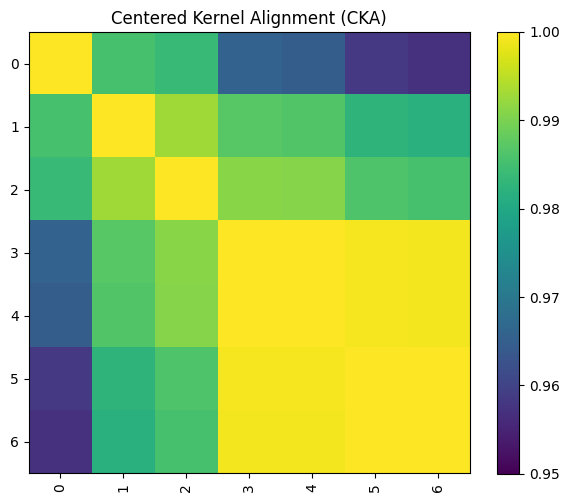

In [23]:
loaded_matrix = load_cka_matrix("./cka_matrix_same_data_diff_prompt_n128.pkl")
print(f"min: {np.min(loaded_matrix)}, max: {np.max(loaded_matrix)}")
plot_cka_matrix(cka_mat=loaded_matrix, vmin=0.95, vmax=1, layer_names=layers[1:])

In [25]:
print_matrix(loaded_matrix)

1.0000  0.9854  0.9840  0.9656  0.9648  0.9583  0.9572
0.9854  1.0000  0.9928  0.9870  0.9864  0.9825  0.9817
0.9840  0.9928  1.0000  0.9911  0.9910  0.9862  0.9854
0.9656  0.9870  0.9911  1.0000  0.9999  0.9993  0.9991
0.9648  0.9864  0.9910  0.9999  1.0000  0.9994  0.9992
0.9583  0.9825  0.9862  0.9993  0.9994  1.0000  1.0000
0.9572  0.9817  0.9854  0.9991  0.9992  1.0000  1.0000


# Train raw MLP

In [13]:
# Load datasets
X_test, y_test, test_ds, X_train, y_train, train_ds = load_tabllm_datasets(test_list=["bank", "income"],
                                                                           train_list=["calhousing"],
                                                                           balanced={"train": True, "val": False, "test": False},
                                                                           test_ratio=0.8,
                                                                           train_ratio=0.1)

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test, dtype=torch.long)

test_list: ['bank', 'income'], X_test.shape: (75243, 103), y_test.shape: (75243,)
train_list: ['calhousing'], X_train.shape: (1904, 103), y_train.shape: (1904,)


In [14]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, X):
        return self.model(X)

In [15]:
def train_mlp_with_loaders(model, 
                           X_train, y_train, 
                           X_test, y_test, 
                           batch_size=32, 
                           epochs=20, 
                           lr=1e-3, 
                           device='cuda'):
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Metric storage
    train_acc_list, val_acc_list = [], []
    train_bal_acc_list, val_bal_acc_list = [], []

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        # ---- Compute train metrics ----
        model.eval()
        train_true, train_pred = [], []
        with torch.no_grad():
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb).argmax(dim=1)
                train_true.extend(yb.cpu().numpy())
                train_pred.extend(preds.cpu().numpy())
        train_acc = accuracy_score(train_true, train_pred)
        train_bal_acc = balanced_accuracy_score(train_true, train_pred)

        # ---- Compute validation metrics ----
        val_true, val_pred = [], []
        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb).argmax(dim=1)
                val_true.extend(yb.cpu().numpy())
                val_pred.extend(preds.cpu().numpy())
        val_acc = accuracy_score(val_true, val_pred)
        val_bal_acc = balanced_accuracy_score(val_true, val_pred)

        # Store
        train_acc_list.append(train_acc)
        train_bal_acc_list.append(train_bal_acc)
        val_acc_list.append(val_acc)
        val_bal_acc_list.append(val_bal_acc)

        tqdm.write(
            f"Epoch {epoch+1}/{epochs} "
            f"- Train Acc: {train_acc:.4f}, Train BalAcc: {train_bal_acc:.4f} "
            f"- Val Acc: {val_acc:.4f}, Val BalAcc: {val_bal_acc:.4f}"
        )

    # ---- Plot ----
    plt.figure(figsize=(10,5))
    plt.plot(range(1, epochs+1), train_acc_list, label='Train Accuracy', marker='x')
    plt.plot(range(1, epochs+1), val_acc_list, label='Val Accuracy', marker='x')
    plt.plot(range(1, epochs+1), train_bal_acc_list, label='Train Balanced Acc', marker='s')
    plt.plot(range(1, epochs+1), val_bal_acc_list, label='Val Balanced Acc', marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Train vs Validation Metrics per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "train_acc": train_acc_list,
        "train_bal_acc": train_bal_acc_list,
        "val_acc": val_acc_list,
        "val_bal_acc": val_bal_acc_list
    }

Epoch 1/20 - Train Acc: 0.5000, Train BalAcc: 0.5000 - Val Acc: 0.1908, Val BalAcc: 0.5000


Epoch 2/20 - Train Acc: 0.7910, Train BalAcc: 0.7910 - Val Acc: 0.5612, Val BalAcc: 0.6355


Epoch 3/20 - Train Acc: 0.8099, Train BalAcc: 0.8099 - Val Acc: 0.5263, Val BalAcc: 0.6231


Epoch 4/20 - Train Acc: 0.8151, Train BalAcc: 0.8151 - Val Acc: 0.5203, Val BalAcc: 0.6204


Epoch 5/20 - Train Acc: 0.8178, Train BalAcc: 0.8178 - Val Acc: 0.5164, Val BalAcc: 0.6186


Epoch 6/20 - Train Acc: 0.8178, Train BalAcc: 0.8178 - Val Acc: 0.5364, Val BalAcc: 0.6209


Epoch 7/20 - Train Acc: 0.8283, Train BalAcc: 0.8283 - Val Acc: 0.5007, Val BalAcc: 0.6134


Epoch 8/20 - Train Acc: 0.8272, Train BalAcc: 0.8272 - Val Acc: 0.4666, Val BalAcc: 0.6043


Epoch 9/20 - Train Acc: 0.8361, Train BalAcc: 0.8361 - Val Acc: 0.4330, Val BalAcc: 0.5937


Epoch 10/20 - Train Acc: 0.8372, Train BalAcc: 0.8372 - Val Acc: 0.4209, Val BalAcc: 0.5900


Epoch 11/20 - Train Acc: 0.8382, Train BalAcc: 0.8382 - Val Acc: 0.4535, Val BalAcc: 0.5989


Epoch 12/20 - Train Acc: 0.8382, Train BalAcc: 0.8382 - Val Acc: 0.4150, Val BalAcc: 0.5876


Epoch 13/20 - Train Acc: 0.8419, Train BalAcc: 0.8419 - Val Acc: 0.4039, Val BalAcc: 0.5845


Epoch 14/20 - Train Acc: 0.8409, Train BalAcc: 0.8409 - Val Acc: 0.4373, Val BalAcc: 0.5944


Epoch 15/20 - Train Acc: 0.8466, Train BalAcc: 0.8466 - Val Acc: 0.4186, Val BalAcc: 0.5882


Epoch 16/20 - Train Acc: 0.8466, Train BalAcc: 0.8466 - Val Acc: 0.4338, Val BalAcc: 0.5931


Epoch 17/20 - Train Acc: 0.8487, Train BalAcc: 0.8487 - Val Acc: 0.3979, Val BalAcc: 0.5813


Epoch 18/20 - Train Acc: 0.8477, Train BalAcc: 0.8477 - Val Acc: 0.4237, Val BalAcc: 0.5900


Epoch 19/20 - Train Acc: 0.8409, Train BalAcc: 0.8409 - Val Acc: 0.4493, Val BalAcc: 0.5977


Epoch 20/20 - Train Acc: 0.8514, Train BalAcc: 0.8514 - Val Acc: 0.4190, Val BalAcc: 0.5888


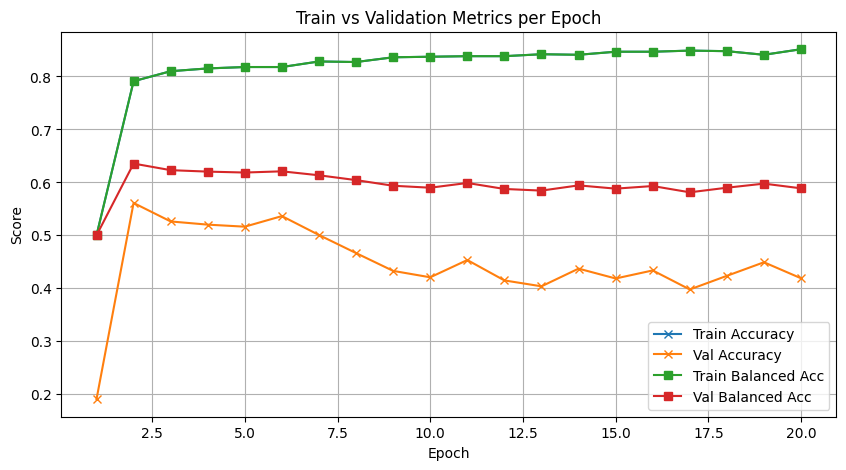

In [16]:
mlp = MLP(in_dim=103, hidden_dim=10, out_dim=2)
n_cols_test = X_test.shape[1]
perm = np.random.randint(low=0, high=n_cols_test, size=n_cols_test)
metrics = train_mlp_with_loaders(model=mlp, 
                                 X_train=X_train, 
                                 y_train=y_train, 
                                 X_test=X_test[:, perm], 
                                 y_test=y_test)

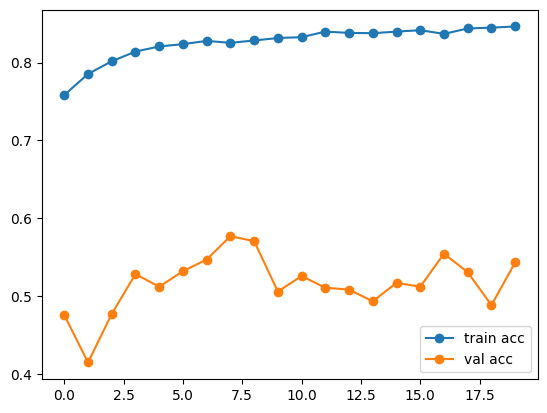

In [52]:
plt.plot(metrics["train_acc"], label="train acc", marker="o")
plt.plot(metrics["val_acc"], label="val acc", marker="o")
plt.legend()